In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pylab as plt
import numpy as np
import torch
import swyft as swyft

In [22]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.on_after_forward = swyft.to_numpy32
        
    def forward(self, trace):
        z = trace.sample('z', np.random.rand, 3)
        x = trace.sample('x', lambda z: z + np.random.randn(3)*0.02, z)

In [23]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.classifier = swyft.RatioEstimatorMLP1d(3, 3)
        
    def forward(self, A, B):
        x = A['x']
        z = B['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [24]:
simulator = Simulator()
samples = simulator(10000)

100%|██████████| 10000/10000 [00:00<00:00, 58981.99it/s]


In [25]:
dl_train = samples[:8000].get_dataloader(batch_size = 128, shuffle = True)
dl_valid = samples[8000:9000].get_dataloader(batch_size = 128)
dl_test = samples[9000:].get_dataloader(batch_size = 128)

In [26]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [27]:
network = Network()

In [28]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | classifier | RatioEstimatorMLP1d | 52.6 K
---------------------------------------------------
52.6 K    Trainable params
0         Non-trainable params
52.6 K    Total params
0.210     Total estimated model params size (MB)


Epoch 0:  90%|█████████ | 64/71 [00:00<00:00, 96.08it/s, loss=-2.93, v_num=9746371] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▊ | 63/71 [00:00<00:00, 97.76it/s, loss=-3.06, v_num=9746371, val_loss=-2.84] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▊ | 63/71 [00:00<00:00, 88.40it/s, loss=-3.09, v_num=9746371, val_loss=-2.89] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▊ | 63/71 [00:00<00:00, 83.03it/s, loss=-3.08, v_num=9746371, val_loss=-3.10]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▊ | 63/71 [00:00<00:00, 98.70it/s, loss=-3.13, v_num=9746371, val_loss=-3.07]
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▊ | 63/71 [00:00<00:00, 97.18it/s, loss=-3.14, v_num=9746371, val_loss=-3.14] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▊ | 63/71 [00:00<00:00, 84.94it/s, loss=-3.14, v_num=9746371, val_loss=-3.07] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  89%|████████▊ | 63/71 [00:00<00:00, 94.30it/s, loss=-3.14, v_num=9746371, val_loss=-

In [10]:
trainer.test(network, dl_test, ckpt_path = 'best')

Restoring states from the checkpoint path at ./lightning_logs/01-minimal-example/version_4/checkpoints/epoch=6-step=440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/01-minimal-example/version_4/checkpoints/epoch=6-step=440.ckpt
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': -3.1546218395233154, 'hp/KL-div': -7.827962398529053}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 8/8 [00:00<00:00, 122.41it/s]


[{'hp/JS-div': -3.1546218395233154, 'hp/KL-div': -7.827962398529053}]

In [11]:
x0 = [0.3, 0.5, 0.7]
prior_samples = simulator(10000, targets = ['z'])

100%|██████████| 10000/10000 [00:00<00:00, 65259.77it/s]


In [12]:
predictions = trainer.infer(network, {'x': torch.tensor(x0)}, prior_samples.get_dataloader(batch_size = 1024))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 63it [00:00, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 63it [00:00, ?it/s]


In [13]:
post_samples = predictions.sample(100000)

0.020028636
0.019460473
0.019212648


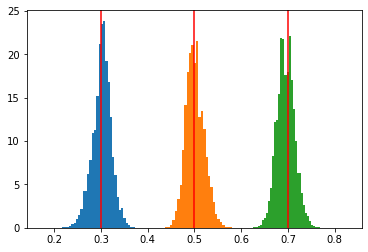

In [14]:
import pylab as plt
for i in range(3):
    s = post_samples['z'][:,i].numpy()
    print(s.std())
    plt.hist(s, bins = 50, density=True);
    plt.axvline(x0[i], color='r')